In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Disable oneDNN custom operations

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [2]:
import joblib
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense
from keras.losses import MeanSquaredError
from keras.models import Sequential
from keras.optimizers import Adam
from pathlib import Path
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from typing import Dict, Literal

from romgw.config.env import PROJECT_ROOT
from romgw.deep_learning.preprocessing import train_val_split, log_q, exp_q
from romgw.typing.core import BBHSpinType, ModeType, ComponentType, RealArray
from romgw.typing.utils import validate_literal
from romgw.waveform.dataset import ComponentWaveformDataset

In [ ]:
bbh_spin: BBHSpinType = "NS"
mode: ModeType = "2,2"
component: ComponentType = "phase"
model_name = f"NonLinearRegression"

In [4]:
# ----- Validate literals -----
bbh_spin = validate_literal(bbh_spin, BBHSpinType)
mode = validate_literal(mode, ModeType)
component = validate_literal(component, ComponentType)

In [5]:
# ----- Root directory for IO operations -----
data_dir = PROJECT_ROOT / "data" / bbh_spin / "train" / mode / component

In [6]:
def load_raw_data(
    bbh_spin: BBHSpinType,
    mode: ModeType,
    component: ComponentType,
) -> tuple[RealArray, RealArray]:
    """"""
    # Validate literals. Raises error if invalid.
    bbh_spin = validate_literal(bbh_spin, BBHSpinType)
    mode = validate_literal(mode, ModeType)
    component = validate_literal(component, ComponentType)

    # Root directory for IO operations.
    data_dir = PROJECT_ROOT / "data" / bbh_spin / "train" / mode / component

    # Load waveforms.
    wf_dir = data_dir / "raw"
    waveforms = ComponentWaveformDataset.from_directory(wf_dir,
                                                        component=component)

    # Load empirical time nodes.
    empirical_time_nodes_file = (
        data_dir / "empirical_interpolation" / "empirical_time_nodes.npy"
    )
    empirical_time_nodes = np.load(empirical_time_nodes_file,
                                   allow_pickle=False)

    # Make X and Y data arrays.
    X_raw = waveforms.params_array
    Y_raw = waveforms.array[:, empirical_time_nodes]

    return X_raw, Y_raw

In [7]:
def make_x_scaler(
    X_raw: RealArray,
    model_dir: str | Path,
) -> None:
    """"""
    model_dir.mkdir(parents=True, exist_ok=True)

    # Transform and scale mass ratio, leaving spins untouched.
    q_log_transformer = Pipeline([
        ('log', FunctionTransformer(log_q, exp_q, validate=False)),
        # ('scale', StandardScaler())
        ('scale', MinMaxScaler())
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('q_log', q_log_transformer, [0]),
        ]
    )
    scaler = preprocessor.fit(X_raw)

    # Save x scaler: need this to make predictions once the model is trained.
    scaler_file = model_dir / f"x_scaler.gz"
    joblib.dump(scaler, scaler_file)

In [8]:
def make_y_scaler(
    Y_raw: RealArray,
    model_dir: str | Path,
) -> None:
    """"""
    model_dir.mkdir(parents=True, exist_ok=True)
    
    # preprocessor = StandardScaler()
    preprocessor = MinMaxScaler()
    scaler = preprocessor.fit(Y_raw)

    # Save y scaler: need this to scale predictions back to physical values.
    scaler_file = model_dir / f"y_scaler.gz"
    joblib.dump(scaler, scaler_file)

In [9]:
def load_scaler(x_or_y: Literal["x", "y"], model_dir: str | Path):
    """"""
    validate_literal(x_or_y, Literal["x", "y"])
    scaler_file = model_dir / f"{x_or_y}_scaler.gz"
    scaler = joblib.load(scaler_file)
    return scaler

In [10]:
# ===== Preprocess data =====

# Load raw data.
X_raw, Y_raw = load_raw_data(bbh_spin, mode, component)

# Directory for IO operations.
model_dir = data_dir / "models" / model_name
model_dir.mkdir(parents=True, exist_ok=True)

# Make data scalers.
make_x_scaler(X_raw, model_dir)
make_y_scaler(Y_raw, model_dir)

# Load data scalers.
x_scaler = load_scaler("x", model_dir)
y_scaler = load_scaler("y", model_dir)

# Scale data.
X = x_scaler.transform(X_raw)
Y = y_scaler.transform(Y_raw)

# Split data into _train and _test.
X_train, X_val, Y_train, Y_val = train_val_split(X, Y)

Waveforms loaded.                                                               


In [11]:
# ===== Build the model =====

# Model architecure.
n_xfeatures = X_train.shape[1]
n_yfeatures = Y_train.shape[1]

if component == "amplitude":
    model = Sequential([
        Dense(n_xfeatures, activation='linear'),
        Dense(59, activation='relu'),
        Dense(29, activation='relu'),
        Dense(19, activation='relu'),
        Dense(n_yfeatures, activation='linear')
    ])
else:  # if component == "phase"
    model = Sequential([
        Dense(n_xfeatures, activation='linear'),
        Dense(256, activation='sigmoid'),
        Dense(256, activation='sigmoid'),
        Dense(n_yfeatures, activation='linear')
    ])

In [12]:
# ----- Component-dependent kwargs -----
optimiser_kwargs = {
    "amplitude": {
        "epsilon": 1e-6,
        "learning_rate": 1e-2
    },
    "phase": {
        "epsilon": 1e-6,
        "learning_rate": 1e-2
    }
}
lrop_kwargs = {
    "amplitude": {
        "factor": 0.8,
        "patience": 32,
        "min_lr": 1e-8
    },
    "phase": {
        "factor": 0.5,
        "patience": 32,
        "min_lr": 1e-8
    }
}
early_stopping_kwargs = {
    "amplitude": {
        "patience": 128
    },
    "phase": {
        "patience": 256
    }
}
fit_kwargs = {
    "amplitude": {
        "epochs": 1000,
        "batch_size": 64
    },
    "phase": {
        "epochs": 1000,
        "batch_size": 64
    }
}

In [13]:
# ----- Model optimisers/callbacks -----

# Loss function.
loss_fn = MeanSquaredError()

# Optimiser.
optimiser = Adam(**optimiser_kwargs[component])

# Reduce learning rate on plateau -> 'incentivise' finding local minima.
lrop = ReduceLROnPlateau(monitor='val_loss', **lrop_kwargs[component])

# Stop early if not reducing validation loss (patient) -> save compute.
early_stopping = EarlyStopping(monitor='val_loss',
                                **early_stopping_kwargs[component],
                                restore_best_weights=True)

# Compile model -> ready for training.
model.compile(optimizer=optimiser, loss=loss_fn)

Epoch 1/1000
52/52 - 2s - 30ms/step - loss: 0.1275 - val_loss: 0.0760 - learning_rate: 0.0100
Epoch 2/1000
52/52 - 0s - 5ms/step - loss: 0.0483 - val_loss: 0.0049 - learning_rate: 0.0100
Epoch 3/1000
52/52 - 0s - 6ms/step - loss: 0.0035 - val_loss: 0.0028 - learning_rate: 0.0100
Epoch 4/1000
52/52 - 0s - 5ms/step - loss: 0.0029 - val_loss: 0.0035 - learning_rate: 0.0100
Epoch 5/1000
52/52 - 0s - 5ms/step - loss: 0.0030 - val_loss: 0.0032 - learning_rate: 0.0100
Epoch 6/1000
52/52 - 0s - 5ms/step - loss: 0.0029 - val_loss: 0.0027 - learning_rate: 0.0100
Epoch 7/1000
52/52 - 0s - 5ms/step - loss: 0.0028 - val_loss: 0.0028 - learning_rate: 0.0100
Epoch 8/1000
52/52 - 0s - 5ms/step - loss: 0.0028 - val_loss: 0.0027 - learning_rate: 0.0100
Epoch 9/1000
52/52 - 0s - 4ms/step - loss: 0.0029 - val_loss: 0.0030 - learning_rate: 0.0100
Epoch 10/1000
52/52 - 0s - 5ms/step - loss: 0.0029 - val_loss: 0.0026 - learning_rate: 0.0100
Epoch 11/1000
52/52 - 0s - 5ms/step - loss: 0.0028 - val_loss: 0.003

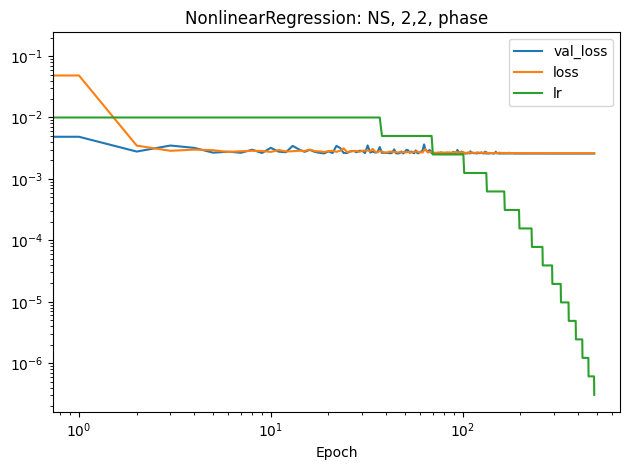

Saved training curve figure to /home/crc972/projects/RedOrModGW/data/NS/train/2,2/phase/models/NonlinearRegression/NonlinearRegression_training_curve.png


In [ ]:
# ----- Train the model -----
history = model.fit(x=X_train,
                    y=Y_train,
                    validation_data=(X_val, Y_val),
                    **fit_kwargs[component],
                    callbacks=[lrop, early_stopping],
                    shuffle=True,
                    verbose=2)
print(f"Training of {model_name} complete.")

# ----- Visualise gradient descent -----
fig_file = model_dir / "training_curve.png"

# Create plot object
fig, ax = plt.subplots(1, 1)

# Plot (log-log) validation loss, loss, and learning rate
ax.loglog(history.history['val_loss'], label='val_loss')
ax.loglog(history.history['loss'], label='loss')
ax.loglog(history.history['learning_rate'], label='lr')

# Plot labels, legend etc.
ax.set_title(f"{model_name}: {bbh_spin}, {mode}, {component}")
ax.set_xlabel("Epoch")
ax.legend()

# Tight layout (personal preference)
fig.tight_layout()

# Save figure
plt.savefig(fig_file)
plt.show()
print(f"Saved training curve figure to {fig_file}")

In [ ]:
# ----- Save model -----
model_file = model_dir / "model.keras"

keras.models.save_model(model=model, filepath=model_file)
print(f"Saved model to {model_file}")

Saved model to /home/crc972/projects/RedOrModGW/data/NS/train/2,2/phase/models/NonlinearRegression/model.keras


In [16]:
# def main(
#     model_name: str,
#     spin: str,
#     mode: str,
#     component: str,
#     optimiser_kwargs: Dict,
#     lrop_kwargs: Dict,
#     early_stopping_kwargs: Dict,
#     fit_kwargs: Dict
# ) -> None:
#     """"""


# if __name__ == "__main__":


#     main(model_name="NonLinRegV1",
#          spin="NS",
#          mode="2,2",
#          component="phase",
#          optimiser_kwargs=optimiser_kwargs,
#          lrop_kwargs=lrop_kwargs,
#          early_stopping_kwargs=early_stopping_kwargs,
#          fit_kwargs=fit_kwargs)